In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
len(inf)

6755

In [2]:
!pip install -Uqq tsai

     |████████████████████████████████| 170 kB 5.0 MB/s 
     |████████████████████████████████| 995 kB 40.3 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 206 kB 56.2 MB/s 
     |████████████████████████████████| 2.5 MB 46.7 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 5.8 MB 47.9 MB/s 
     |████████████████████████████████| 9.5 MB 16.4 MB/s 
     |████████████████████████████████| 3.4 MB 51.3 MB/s 
     |████████████████████████████████| 188 kB 60.6 MB/s 
     |████████████████████████████████| 72 kB 906 kB/s 
     |████████████████████████████████| 28.5 MB 73.7 MB/s 
     |████████████████████████████████| 118 kB 56.3 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 776 kB 50.2 MB/s 
     |████████████████████████████████| 113 kB 63.1 MB/s 
     |██████████████

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tsai.all import *
import math

In [109]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

Extract the weights for the different participants in the correct format

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Bernard/timeseries/participant_info_simple.csv',nrows=984, delimiter = ",")
  #df = pd.read_csv(link, delimiter = "\t",skiprows=5,header=None)

In [3]:
import math
sub_mass=[]
sub=[]
mass=[]
for i in range(math.ceil(len(df['Mass'])/24)):
  sub_mass.append(np.array(df[['Subject','Mass']].iloc[i*24]))
sub_mass=np.insert(sub_mass,38, (39,66.35),0) 
  #sub.append(np.array(df['Subject'][i*24]))
  #mass.append(np.array(df['Mass'][i*24]))
#sub=np.insert(sub, 38, 1)   

Import files names

In [4]:
import glob
files1=sorted(glob.glob('/content/drive/MyDrive/Bernaed2/timeseries/s[0-9][0-9]_walkT[0-9][0-9]_S*.txt'))

files2=sorted(glob.glob('/content/drive/MyDrive/Bernaed2/timeseries/s[0-9][0-9]_walkT[0-9][0-9]_E*.txt'))


check if files from events and segment line up

In [5]:
for i in range(len(files2)):
  if files1[i][43:54] != files2[i][43:54]:
    print(i)

Function that segments the data and pad zeroes

In [6]:
def segmenter4(link,link2):

  ### extract participant nbr to have his/her body mass
  sub_nbr=int(link[44:46])
  mass = sub_mass[sub_nbr-1][1]
  info=link[44:54]
  #print(sub_nbr,mass)
### Load file, drop timestamp and index column and 
### replace NAN with next value or previous 
  df = pd.read_csv(link, delimiter = "\t",skiprows=5,header=None)
  
  df=df.fillna(method='backfill')
  df=df.fillna(method='ffill')
### Find indices of zeros in event store them in a and extract 
### the last zero to construct the windows and store in h

  df2 = pd.read_csv(link2, skiprows=[0,1,2,3],delimiter = "\t",usecols=['X'])
  df2 = df2.apply(lambda x: pd.Series(x.dropna().values))

  h=[]
  h.append([0])
  df2=np.array(df2)
  df2=df2.reshape(len(df2))
  for ron in df2[1:len(df2)]:
    h.append(df[df[1] ==ron].index.tolist())
  h = [x for x in h if x]




 
### store predictor in x, outcome in y event in z 

  x=[]
  y=[]
  z=[]
  inf=[]
  counter = 0
  cnt=[]

  # low_limit=110
  # high_limit=300
  
  # for i in range(len(h)-1):
    
    
  #   df_t =df[h[i][0]:h[i+1][0]]
    
    
      
  #   x.append(np.array(df_t.iloc[:,2:128]))
      
      
  #   y.append(np.array(df_t.iloc[:,131]))
  #   z.append(np.array(df_t.iloc[:,147]))
  #   inf.append(info)

  #   counter +=1
  #   cnt.append(counter)

  low_limit=110
  high_limit=300

  for i in range(len(h)-1):
    
    df_t =df[h[i][0]:h[i+1][0]]
   

    if len(df_t)> low_limit and len(df_t) < high_limit:
      npad = high_limit - len(df_t)
      x.append(np.pad(np.array(df_t.iloc[:,2:128]),((0,npad),(0,0)), mode='constant', constant_values=0))
      
      
      y.append(np.pad(np.array(df_t.iloc[:,131])/mass,(0,npad),mode='constant', constant_values=0))
      z.append(np.pad(np.array(df_t.iloc[:,147]),(0,npad),mode='constant', constant_values=0))
      inf.append(info)

      counter +=1
      cnt.append(counter)

  return x,y,z,inf,cnt

Run that function

In [7]:
from tqdm import tqdm
x=[]
y=[]
z=[]
inf=[]
cnt=[]
for i in tqdm(range(len(files1))):

  x_temp,y_temp,z_temp,inf_tmp,cnt_tmp =segmenter4(files1[i],files2[i]) 
  x +=x_temp
  y +=y_temp
  z +=z_temp
  inf +=inf_tmp
  cnt +=cnt_tmp


100%|██████████| 259/259 [02:41<00:00,  1.61it/s]


extract some features to remove noise

In [8]:
stat= np.zeros((len(x),3))
for i in range(len(x)):
  stat[i,0]= max(x[i][:,42])
  stat[i,1]=min(x[i][:,42])
  stat[i,2]=max(x[i][:,42])-min(x[i][:,42])
  # stat[i,3]=inf[i]
  # stat[i,4]=cnt[i]

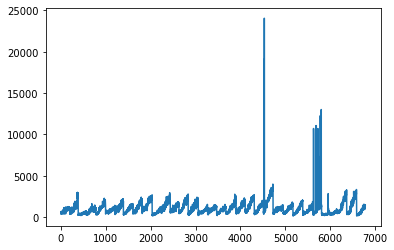

In [9]:
plt.plot(stat[:,0])

extract indices of the noisy segments

In [9]:
bad =[]
for i in range(len(stat)):
  if stat[i,0]> 4500:
    bad.append(i)


sort them in descending order

In [10]:
bad2=sorted(bad, reverse=True)

delete them from X,Y, and other arrays

In [11]:
for i in range(29):
  x = np.delete(x, bad2[i],axis =0)
  y = np.delete(y, bad2[i],axis =0)
  z = np.delete(z, bad2[i],axis =0)
  inf = np.delete(inf, bad2[i],axis =0)
  cnt = np.delete(cnt, bad2[i],axis =0)


compute area from outcome

In [12]:
area = []
for i in range(len(y)):
  area.append(np.trapz(y[i]))
area=np.array(area).reshape(-1,1)
len(y),area.shape

(6755, (6755, 1))

Remove segments where area is positive

In [13]:
ind =[]
for i in range(len(area)):
  if area[i] > 0:
    ind.append(i)



In [14]:
ind2=sorted(ind, reverse=True)

In [15]:
for i in range(18):
  x = np.delete(x, ind2[i],axis =0)
  y = np.delete(y, ind2[i],axis =0)
  z = np.delete(z, ind2[i],axis =0)
  inf = np.delete(inf, ind2[i],axis =0)
  cnt = np.delete(cnt, ind2[i],axis =0)


Recompute area

In [16]:
area = []
for i in range(len(y)):
  y[i][y[i]>0]=0
  area.append(np.trapz(y[i]))
area=np.array(area).reshape(-1,1)


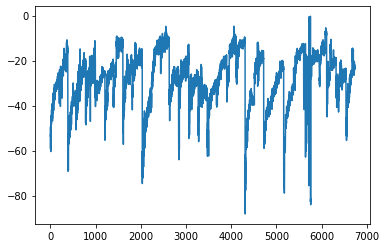

In [106]:
plt.plot(area)

In [46]:
np.savetxt("foo.csv", y[ind[0]]*73.1, delimiter=",", fmt='%f')







Train test splits

In [17]:
X = np.moveaxis(np.array(x), -1, 1)
#X = np.expand_dims(x, axis=3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(area), test_size=0.25, random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_train.shape

((5052, 126, 300), (5052, 1), (1685, 126, 300), (5052, 1))

Regression models

In [110]:
model = Sequential()
#model.add(Dense(256, activation='relu', input_dim=366))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape = X_train[0].shape))

model.add(Conv2D(128, (3, 3), activation='relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='linear'))


model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer='adam',
                  metrics=['mse', 'mae', 'mape'] # you can add several if needed
                 )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 124, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 122, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 61, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1155584)           0         
_________________________________________________________________
dense (Dense)                (None, 512)               591659520 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

In [111]:
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test) )

Epoch 1/100
79/79 [==============================] - 51s 287ms/step - loss: 44411965.3814 - mse: 44411965.3814 - mae: 1924.4274 - mape: 8857.9602 - val_loss: 328.0281 - val_mse: 328.0281 - val_mae: 15.2084 - val_mape: 74.8468
Epoch 2/100
79/79 [==============================] - 21s 267ms/step - loss: 1384.0046 - mse: 1384.0046 - mae: 28.8936 - mape: 124.8068 - val_loss: 164.9844 - val_mse: 164.9844 - val_mae: 9.8818 - val_mape: 37.4656
Epoch 3/100
79/79 [==============================] - 21s 266ms/step - loss: 734.7369 - mse: 734.7369 - mae: 21.2431 - mape: 92.6157 - val_loss: 114.7334 - val_mse: 114.7334 - val_mae: 8.3590 - val_mape: 33.5716
Epoch 4/100
79/79 [==============================] - 21s 260ms/step - loss: 497.2582 - mse: 497.2582 - mae: 17.3263 - mape: 73.6817 - val_loss: 105.1227 - val_mse: 105.1227 - val_mae: 8.2262 - val_mape: 38.7050
Epoch 5/100
79/79 [==============================] - 21s 266ms/step - loss: 366.7668 - mse: 366.7668 - mae: 14.9612 - mape: 67.1853 - val_

In [18]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [19]:
tfms  = [None, [TSRegression()]]

dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=128)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.019054606556892395)

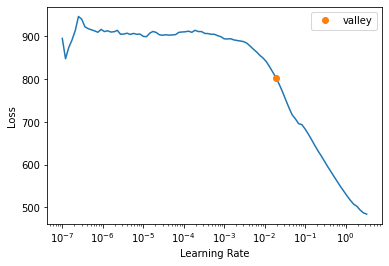

In [20]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,310.089539,12016.413086,103.671562,109.619408,00:02
1,121.130135,121.778488,10.115188,11.035329,00:01
2,58.528305,35.622574,5.103996,5.968465,00:01
3,31.911201,19.709194,3.420108,4.439504,00:01
4,21.357397,24.671410,4.241983,4.967032,00:01
5,14.276561,8.584056,2.147153,2.929856,00:01
6,9.664158,7.763525,2.104726,2.786310,00:01
7,7.891185,15.151683,3.176740,3.892516,00:01
8,6.537678,5.591562,1.702135,2.364648,00:01
9,5.286007,5.615436,1.705016,2.369691,00:01


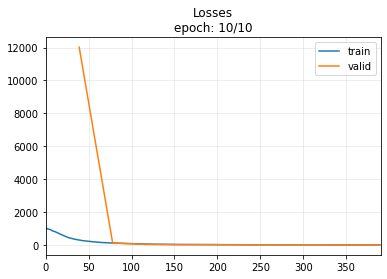

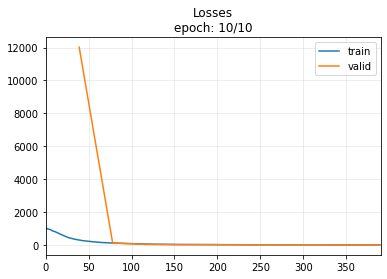

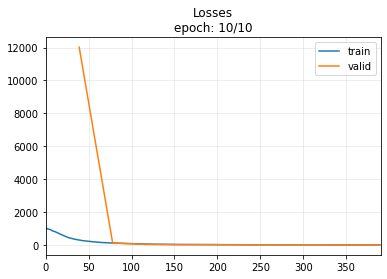

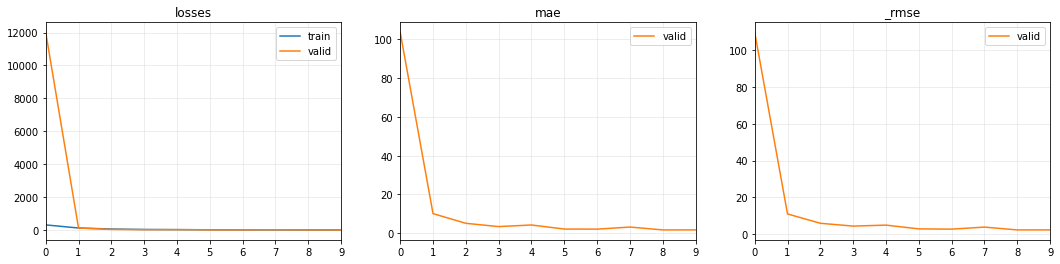

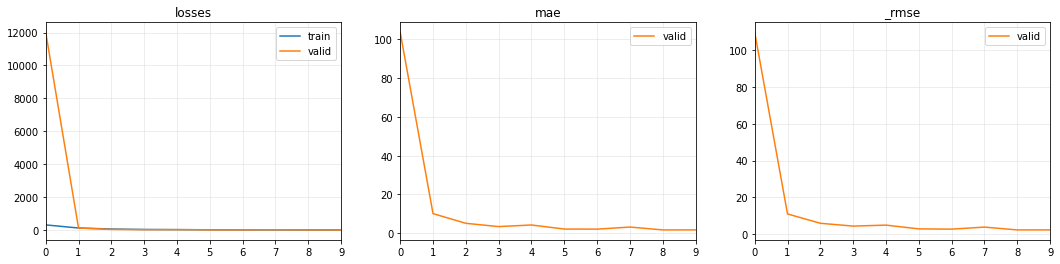

In [20]:
learn.fit_one_cycle(10, lr_max=slice(1e-3,1e-1), cbs=ShowGraph())

epoch,train_loss,valid_loss,mae,_rmse,time
0,294.837860,164800.968750,399.932495,405.956879,00:01
1,114.158844,79.567719,7.160690,8.920074,00:01
2,55.900932,35.421673,5.030529,5.951611,00:01
3,31.460403,23.964378,3.748014,4.895342,00:01
4,22.371220,15.319990,3.096976,3.914076,00:01
5,14.593416,8.436004,2.235194,2.904480,00:01
6,10.877673,6.631480,1.897655,2.575166,00:01
7,9.037131,16.967964,3.492164,4.119219,00:01
8,6.931701,5.874946,1.747438,2.423829,00:01
9,5.830434,5.829924,1.758407,2.414524,00:01


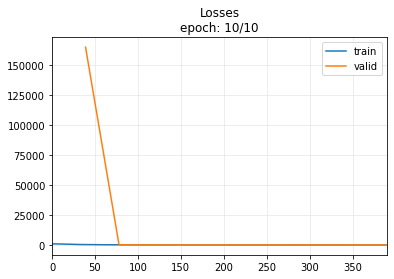

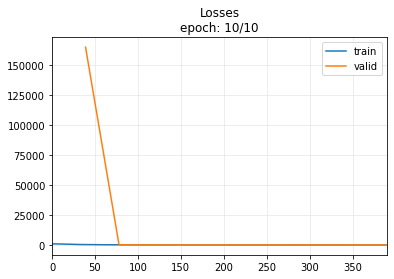

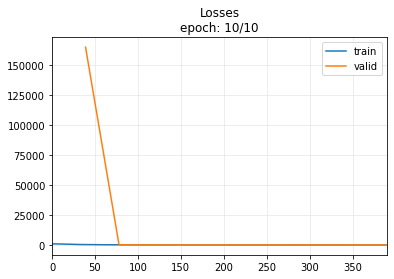

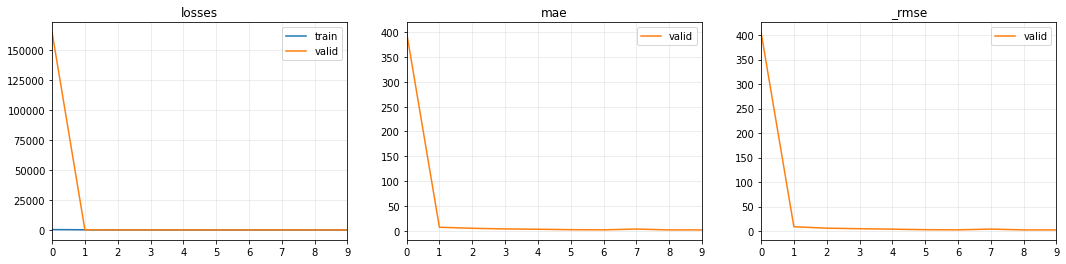

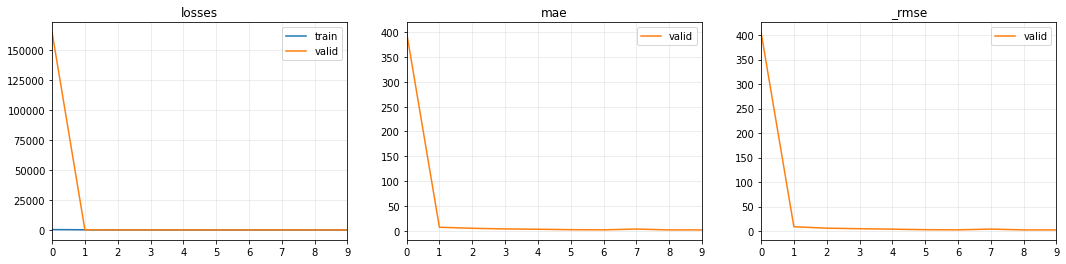

In [21]:
learn.fit_one_cycle(10, lr_max=slice(1e-3,1e-1), cbs=ShowGraph())

SuggestedLRs(valley=5.248074739938602e-05)

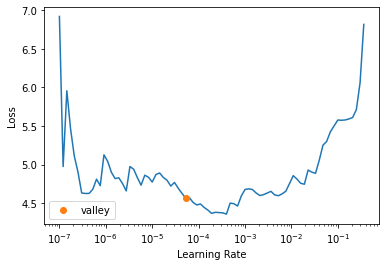

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,4.243022,5.645693,1.718030,2.376067,00:01
1,4.382044,5.555663,1.699154,2.357045,00:01
2,4.282371,5.541217,1.695879,2.353979,00:01


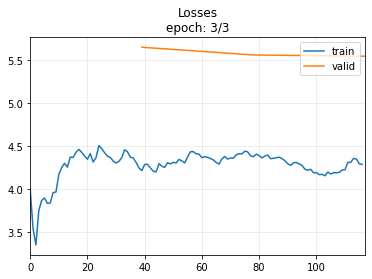

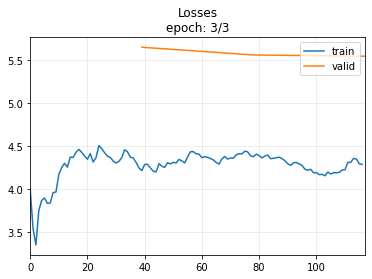

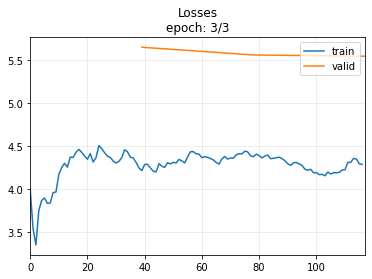

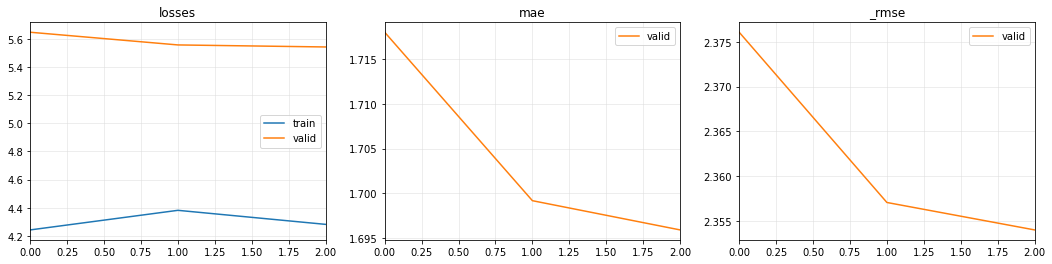

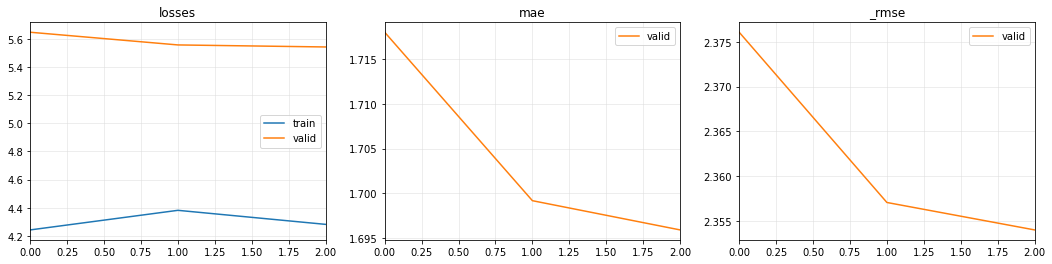

In [23]:
learn.fit_one_cycle(3, lr_max=slice(3e-5,2e-4), cbs=ShowGraph())

In [21]:
learn2 = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn2.unfreeze()

SuggestedLRs(valley=0.010964781977236271)

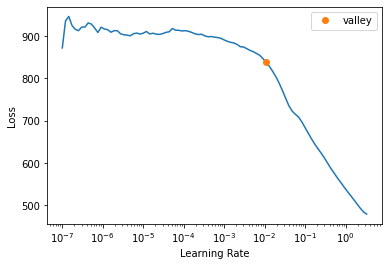

In [22]:
learn2.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,301.266144,35259.980469,182.185684,187.776428,00:01
1,114.534378,29.586821,3.943021,5.439377,00:01
2,58.290241,33.485836,4.701313,5.786695,00:01
3,35.600849,17.838598,3.082161,4.223577,00:01
4,23.195536,22.760834,3.705334,4.770832,00:01
5,15.905109,7.646173,2.032342,2.765171,00:01
6,11.395485,23.050982,4.127011,4.801144,00:01
7,8.538334,6.640658,1.859848,2.576947,00:01
8,6.701561,6.048764,1.758357,2.459424,00:01
9,5.835924,6.094127,1.765617,2.468628,00:01


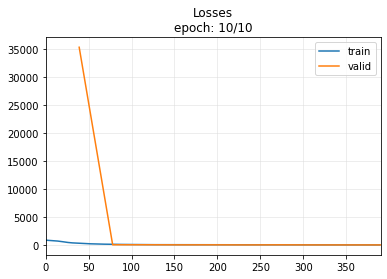

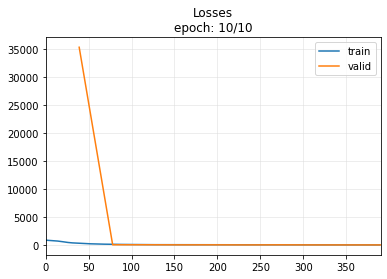

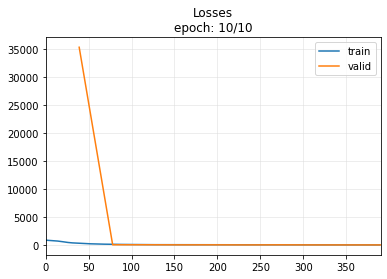

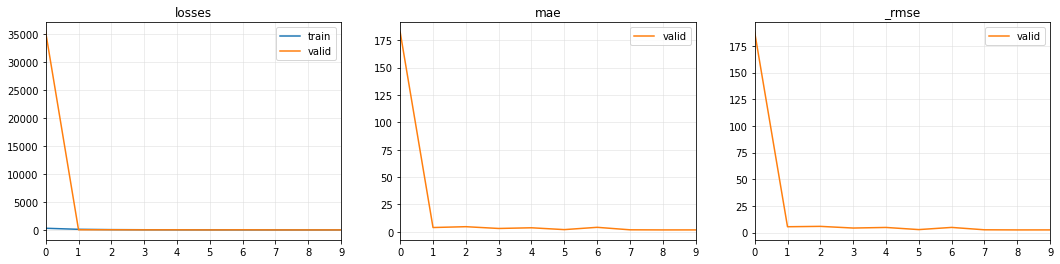

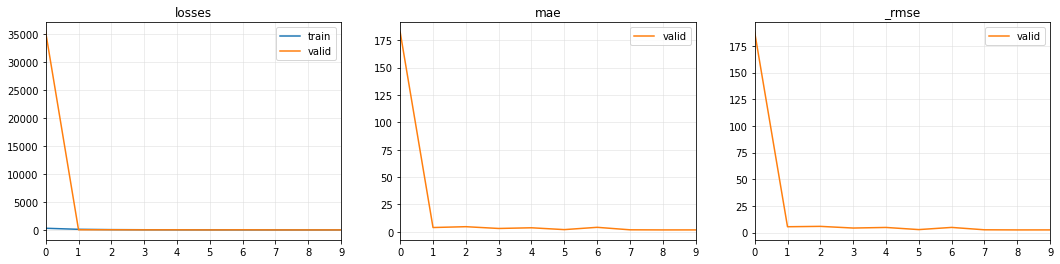

In [23]:
learn2.fit_one_cycle(10, lr_max=slice(7e-3,1e-1), cbs=ShowGraph())

SuggestedLRs(valley=0.2089296132326126)

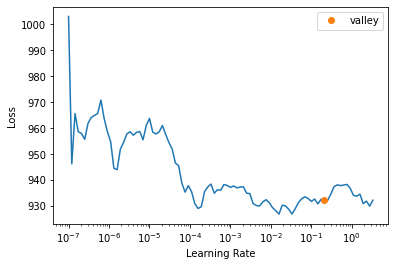

In [24]:
learn3 = ts_learner(dls, XceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn3.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,927.732422,937.283081,28.432571,30.615078,00:02
1,927.620422,931.955505,28.333376,30.527946,00:02
2,928.955261,930.285156,28.295952,30.500576,00:02
3,925.630188,930.886719,28.311979,30.510437,00:02
4,925.294495,929.746094,28.284117,30.491735,00:02
5,924.062134,929.924194,28.287630,30.494658,00:02
6,923.285950,929.881958,28.288273,30.493967,00:02
7,923.019043,929.750305,28.284105,30.491806,00:02
8,922.650085,929.902771,28.289747,30.494308,00:02
9,920.455688,929.739990,28.283876,30.491638,00:02


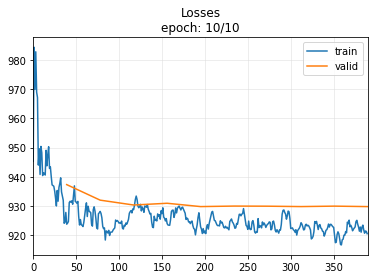

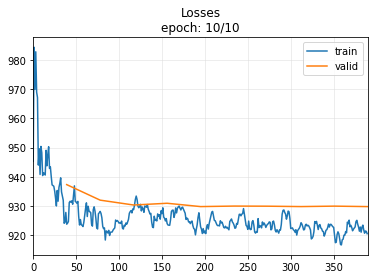

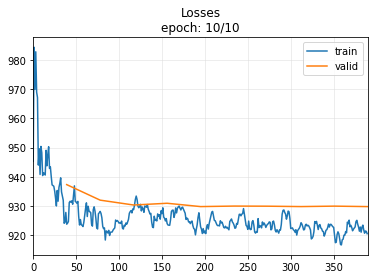

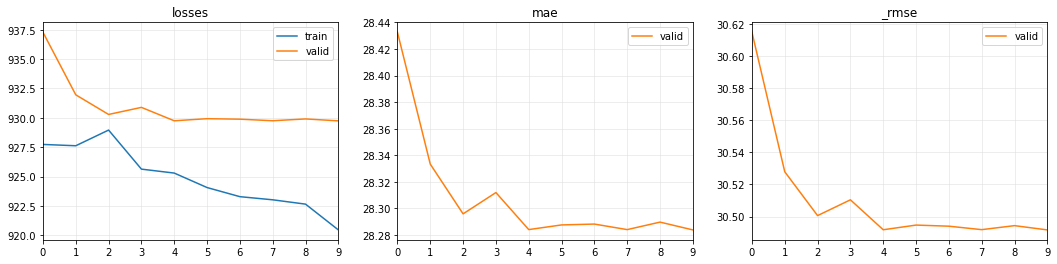

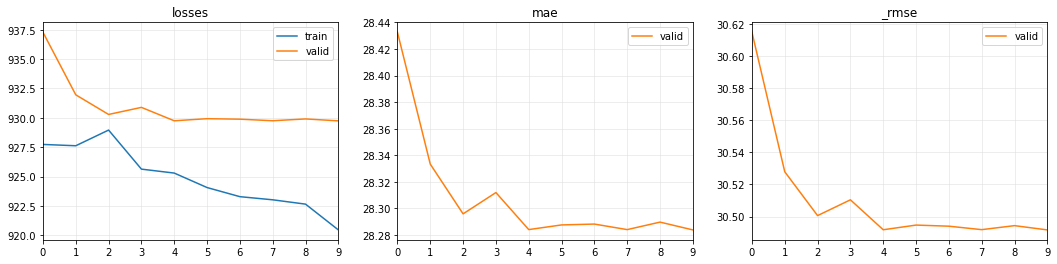

In [25]:
learn3.fit_one_cycle(10,  cbs=ShowGraph())

SuggestedLRs(valley=0.015848932787775993)

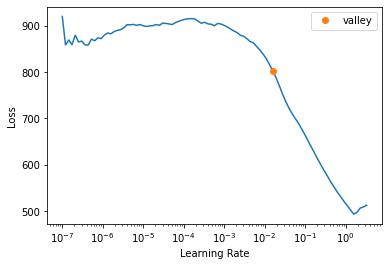

In [26]:
learn4 = ts_learner(dls, RNN_FCN, metrics=[mae, rmse], cbs=ShowGraph())
learn4.lr_find()


epoch,train_loss,valid_loss,mae,_rmse,time
0,275.904053,150.240219,10.199106,12.257252,00:01
1,106.361832,21.545906,3.663551,4.641757,00:01
2,54.034824,17.276615,3.165962,4.156515,00:01
3,32.126938,11.454025,2.547677,3.384379,00:01
4,20.839729,34.432606,5.099287,5.867930,00:01
5,14.434601,9.238103,2.240496,3.039425,00:01
6,10.336113,12.219374,2.845168,3.495622,00:01
7,8.137575,8.513346,2.238935,2.917764,00:01
8,6.399240,6.120908,1.772282,2.474047,00:01
9,5.278995,6.102412,1.768327,2.470306,00:01


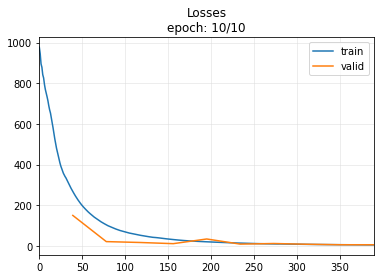

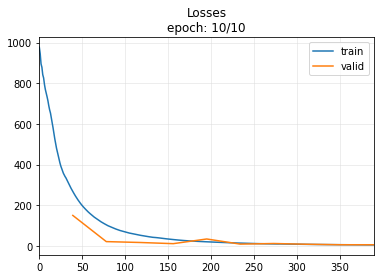

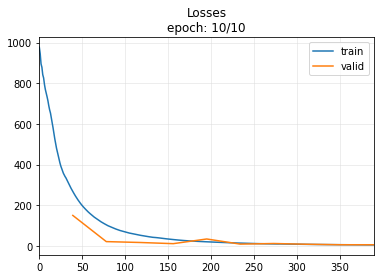

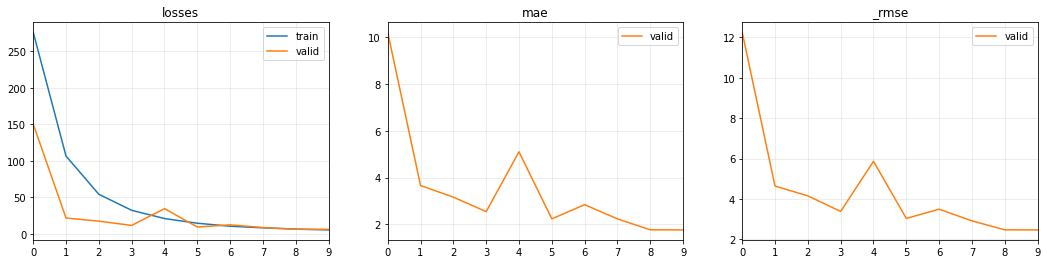

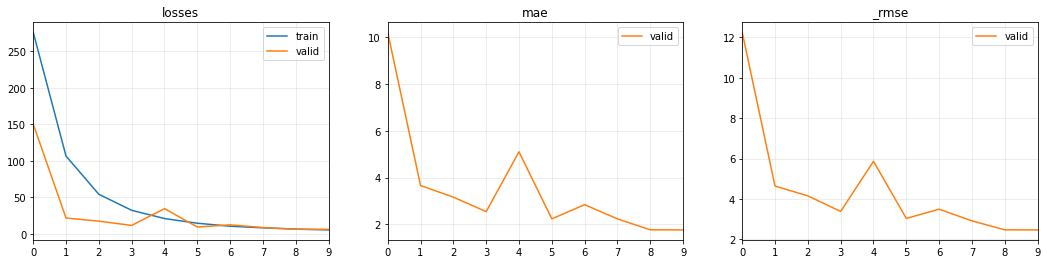

In [27]:
learn4.fit_one_cycle(10,  lr_max=slice(2e-3,1e-1), cbs=ShowGraph())

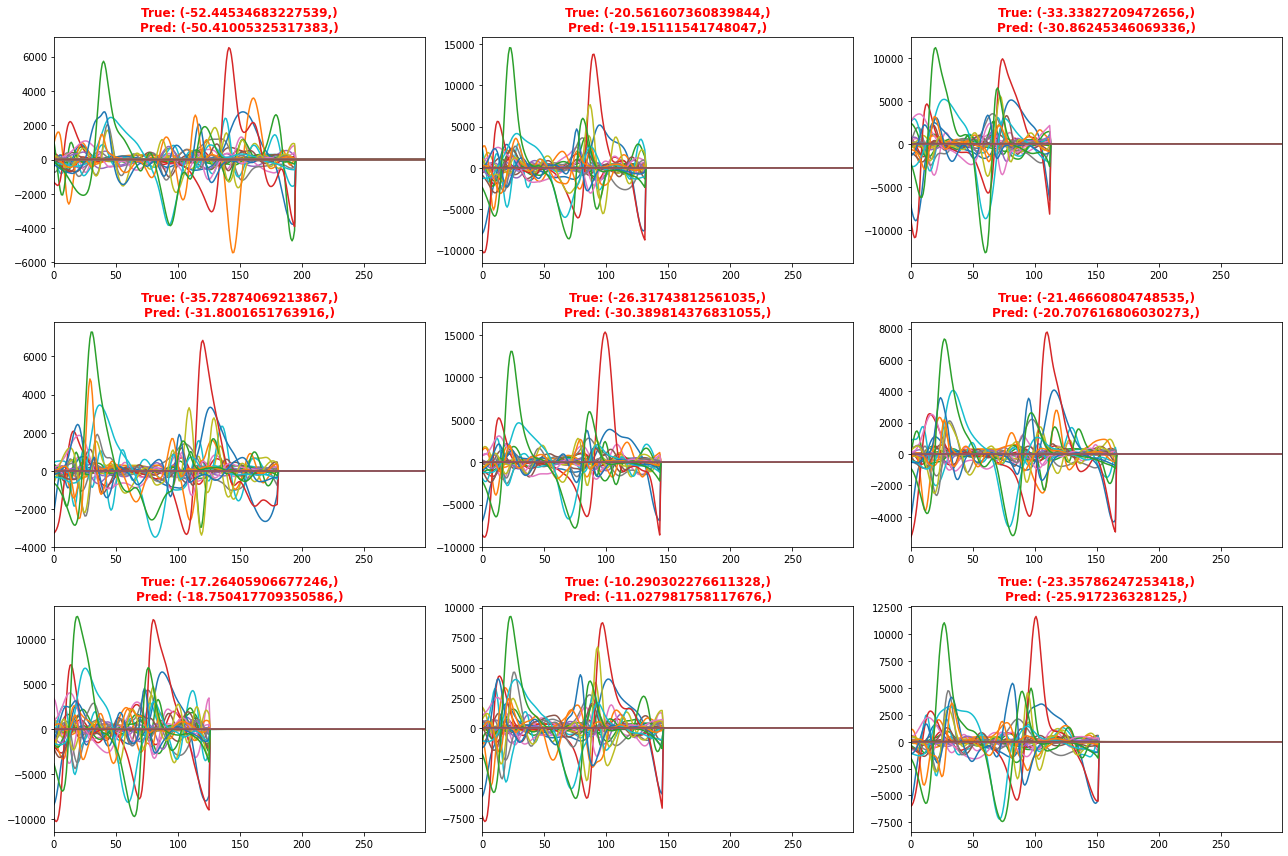

In [24]:
learn.show_results(max_n=9)

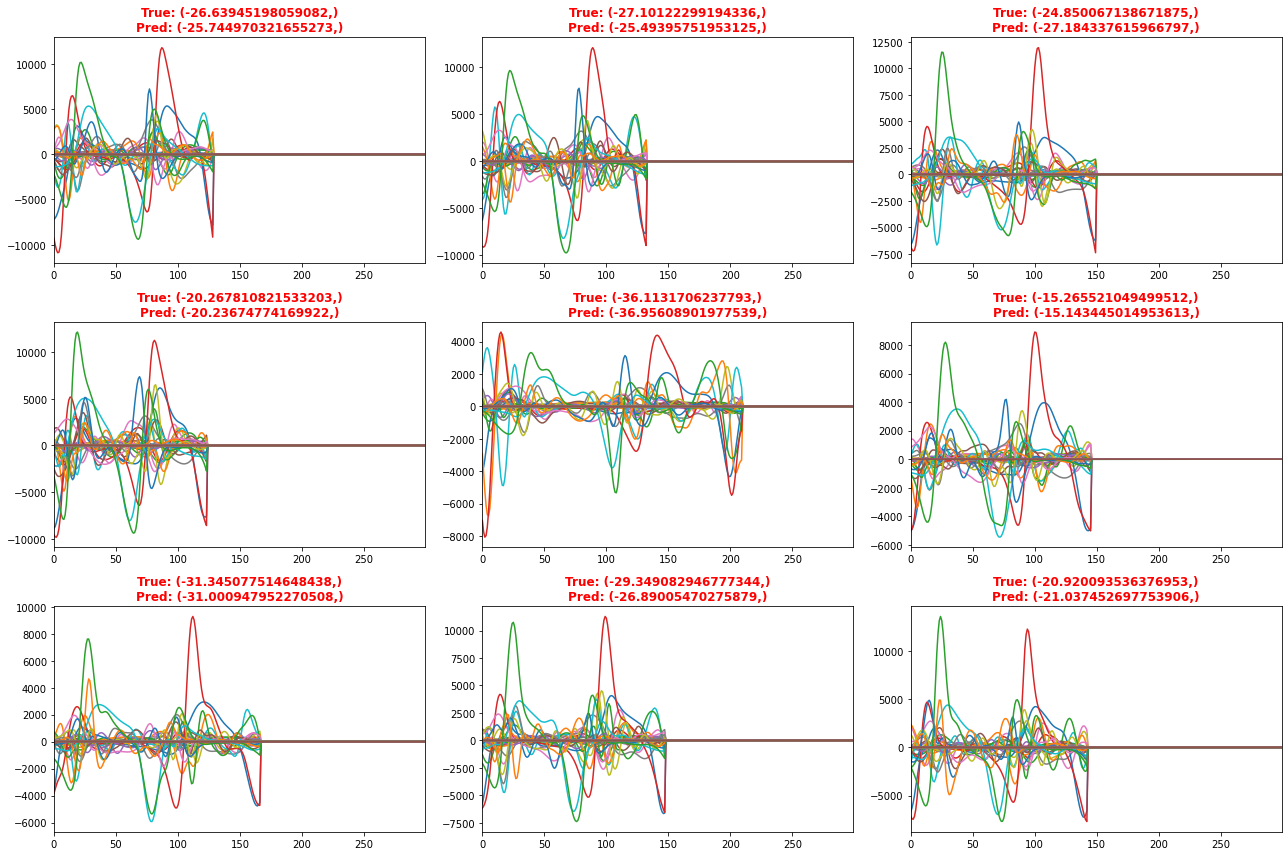

In [25]:
learn.show_results(max_n=9)

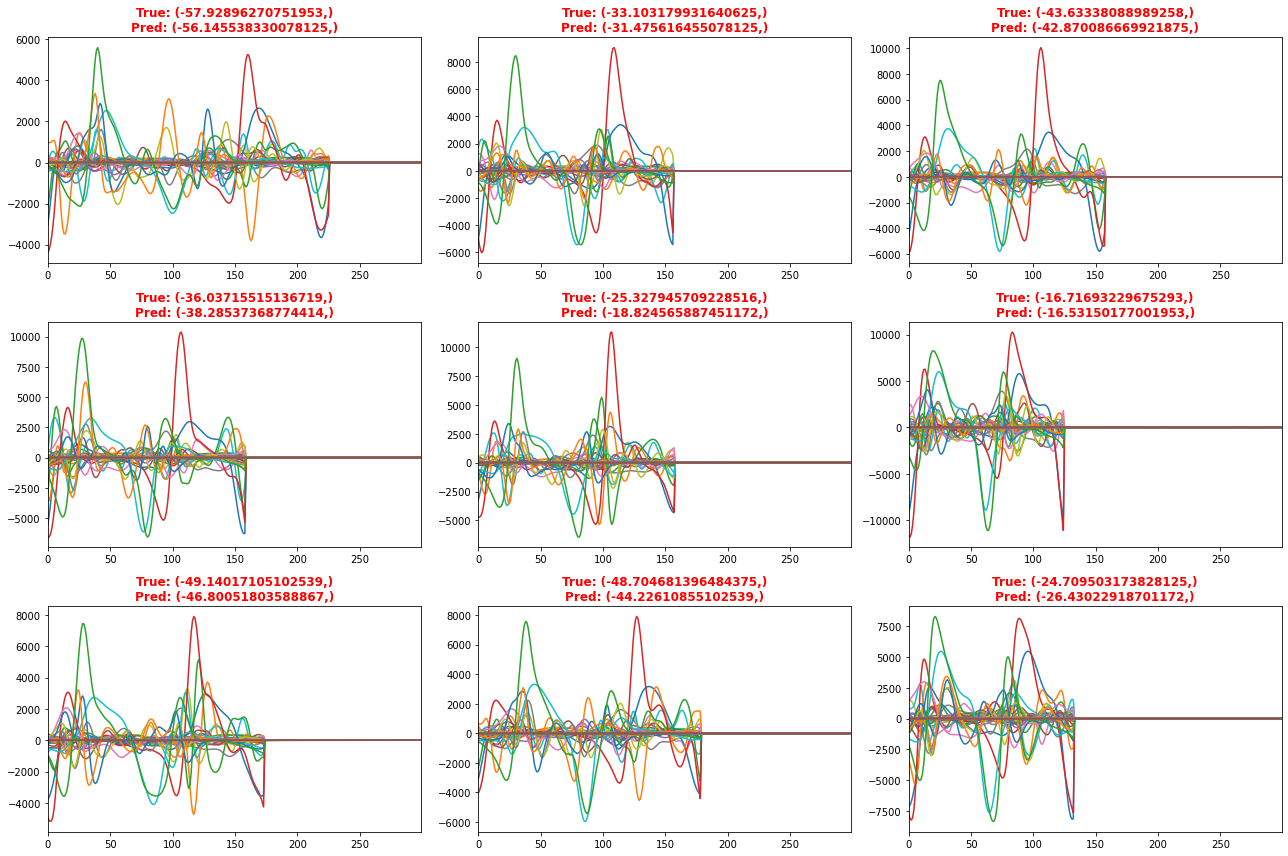

In [86]:
learn.show_results(max_n=9)

SuggestedLRs(valley=0.013182567432522774)

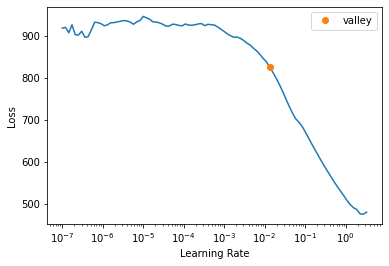

In [29]:
learn5 = ts_learner(dls, ResNet, metrics=[mae, rmse], cbs=ShowGraph())
learn5.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,287.773193,17217.566406,126.224373,131.215729,00:01
1,111.441704,38.184444,4.437287,6.179356,00:01
2,58.492237,27.687757,4.097940,5.261916,00:01
3,33.625771,35.215767,5.017760,5.934288,00:01
4,21.977375,18.429396,3.433854,4.292947,00:01
5,15.517811,24.409702,4.210969,4.940618,00:01
6,11.996078,13.979243,3.054598,3.738883,00:01
7,9.308235,10.931635,2.539694,3.306303,00:01
8,7.240803,7.355473,1.949827,2.712097,00:01
9,6.013070,6.852720,1.861761,2.617770,00:01


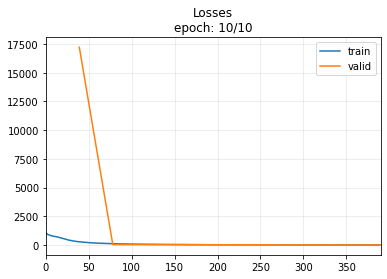

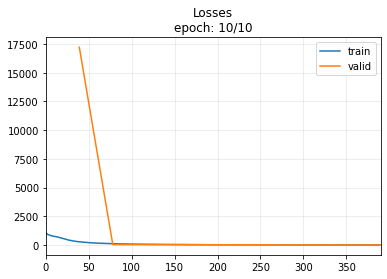

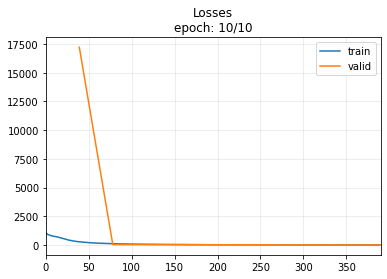

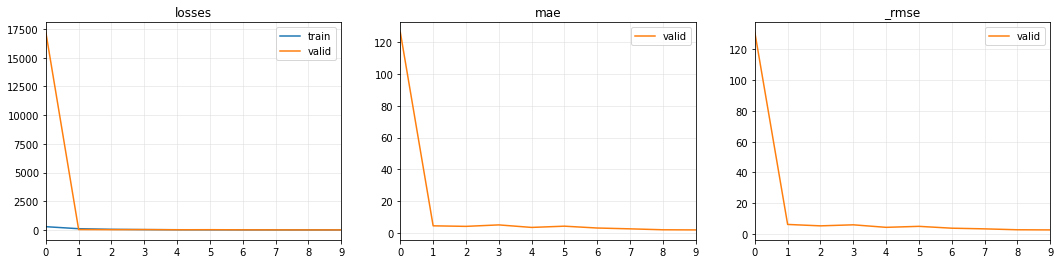

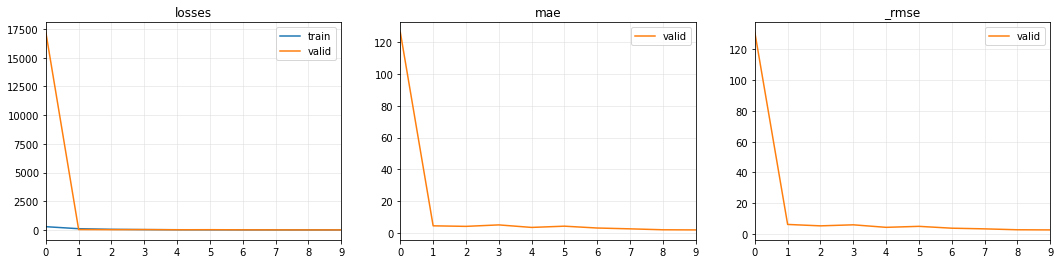

In [30]:
learn5.fit_one_cycle(10,  lr_max=slice(2e-3,1e-1), cbs=ShowGraph())

In [31]:
tfms  = [None, [TSRegression()]]
batch_tfms = [TSNormalize(),TSToGADF(300)]
dsets1 = TSDatasets(X, y, tfms=tfms, splits=splits)
dls1 = TSDataLoaders.from_dsets(dsets1.train, dsets1.valid, bs=[16,32], batch_tfms=batch_tfms)

In [32]:
model = create_model(xresnet18, dls=dls1)
learn6 = Learner(dls1, model,  metrics=[mae, rmse])

SuggestedLRs(valley=0.007585775572806597)

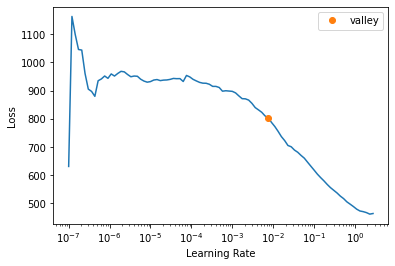

In [33]:
learn6.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,86.615402,6762225.500000,2600.364014,2600.427734,11:22
1,78.369873,859.524353,27.381554,29.317644,12:29
2,79.916885,155.267914,10.174699,12.460655,12:36
3,71.271797,82270.554688,286.552216,286.828400,12:36
4,64.096977,25896.730469,160.560898,160.924606,12:31
5,57.768478,259.839539,12.565071,16.119539,12:29
6,50.891647,65501.523438,255.692810,255.932663,12:28
7,35.346451,272.070221,12.921126,16.494553,12:26
8,27.163759,226974.156250,476.309113,476.417969,12:27
9,19.892294,21.332884,3.447948,4.618753,12:29


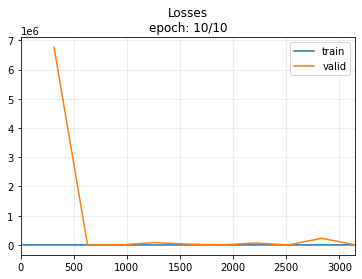

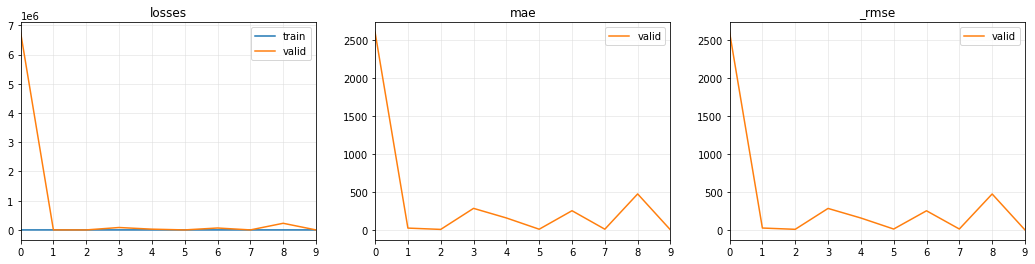

In [34]:
learn6.fit_one_cycle(10,  lr_max=slice(3e-3,8e-1), cbs=ShowGraph())

In [19]:
tfms  = [None, [TSRegression()]]
batch_tfms = [TSNormalize(),TSToGADF(400)]
dsets2 = TSDatasets(X, y, tfms=tfms, splits=splits)
dls2 = TSDataLoaders.from_dsets(dsets2.train, dsets2.valid, bs=[16,32], batch_tfms=batch_tfms)

In [20]:
model7 = create_model(xresnet18, dls=dls2)
learn7 = Learner(dls2, model7,  metrics=[mae, rmse])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.010964781977236271)

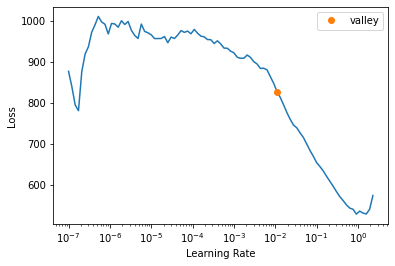

In [21]:
learn7.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,82.230377,393.178070,16.272316,19.828718,20:18
1,75.134689,1653.677246,39.111755,40.665436,20:26
2,83.973885,376.212006,15.837100,19.396187,20:30
3,69.664948,30902.818359,175.420486,175.791962,20:21
4,80.939079,33480.195312,182.604736,182.975937,20:22
5,60.727726,4746.579590,67.951591,68.895416,20:38
6,48.493149,1151.823608,32.071903,33.938526,20:42
7,41.638897,46151.734375,214.525925,214.829544,20:29
8,26.785675,715.710510,24.235668,26.752769,20:26
9,21.366478,25.900764,3.866157,5.089280,20:26


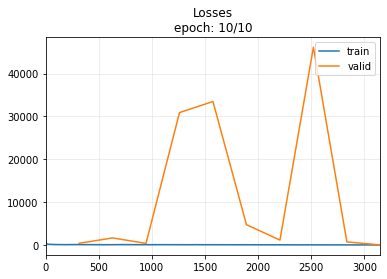

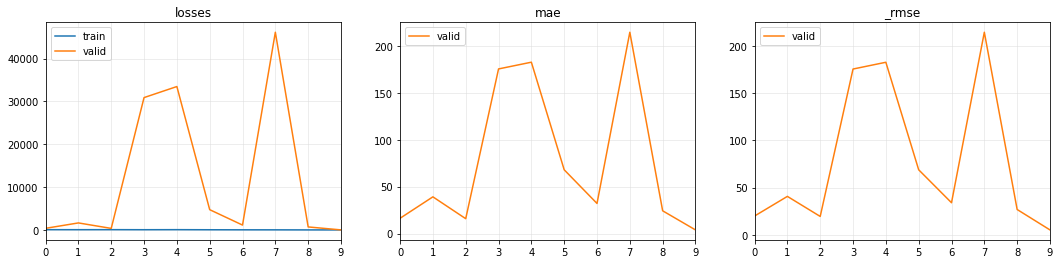

In [22]:
learn7.fit_one_cycle(10,  lr_max=slice(3e-3,8e-1), cbs=ShowGraph())